# OpenCV Overlay: OpticalFlow

<img src=attachment:image.png width=350 align=right>
This notebook extends the examples of OpenCV applications to OpticalFlow. Here we run through the process of computing optical flow in software, profile it and then accelerate it in hardware and measure the performance speedup. OptcalFlow is a more complicated function which measures the movement of objects in a scene and the gains we see when accelerating in FPGA is more significant. OpticalFlow also has a number of algorithmic variations so in this example, we will compare the OpenCV Farneback algorithm with the xFOpenCV dense non-pyramidal Lucas-Kanade algoirthm.
1. Program overlay
2. Run SW OpticalFlow and measure performance
3. Run HW OpticalFlow and measure performance
4. Plot performance

Credit to the original library and Xilinx developers for their hard work: https://github.com/Xilinx/PYNQ-ComputerVision

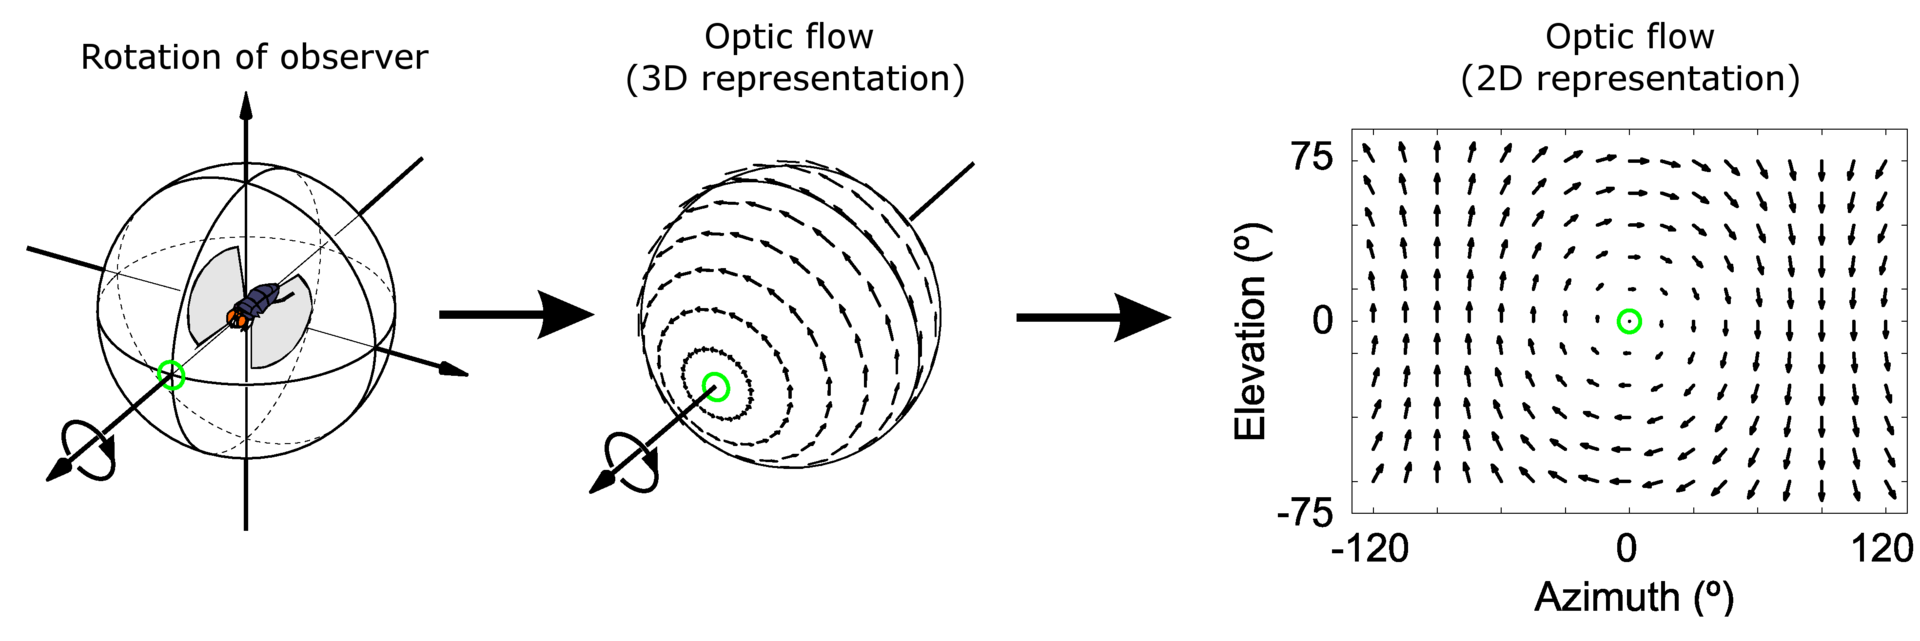

## Program overlay

Here we program the overlay on the FPGA, load the associated overlay library and load the PYNQ xlnk memory manager library.

In [5]:
import cv2 #NOTE: This needs to be loaded first
import numpy as np
import time

# Load calcOpticalFlowDenseNonPyrLK overlay
from pynq import Overlay, get_rails
bs = Overlay("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2CalcOpticalFlowDenseNonPyrLK.bit")
bs.download()

import pynq_cv.overlays.xv2CalcOpticalFlowDenseNonPyrLK as xv2

# Load xlnk memory mangager
from pynq import Xlnk
Xlnk.set_allocator_library('/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2CalcOpticalFlowDenseNonPyrLK.so')
mem_manager = Xlnk()

rails = get_rails()
rail = rails['12V']

print('Power Consumption: {} Watts'.format(rail.power.value))

Power Consumption: 11.275 Watts


## Setup helper functions

Here, we set up IPython based imshow call which encode OpenCV image data to jpeg before displaying it in the notebook. Other methods of displaying image data would perform similar conversions as well.

In [6]:
import IPython

def imshow(img):
    returnValue, buffer = cv2.imencode('.jpg', img)
    IPython.display.display(IPython.display.Image(data=buffer.tobytes()))

# Software Implementation

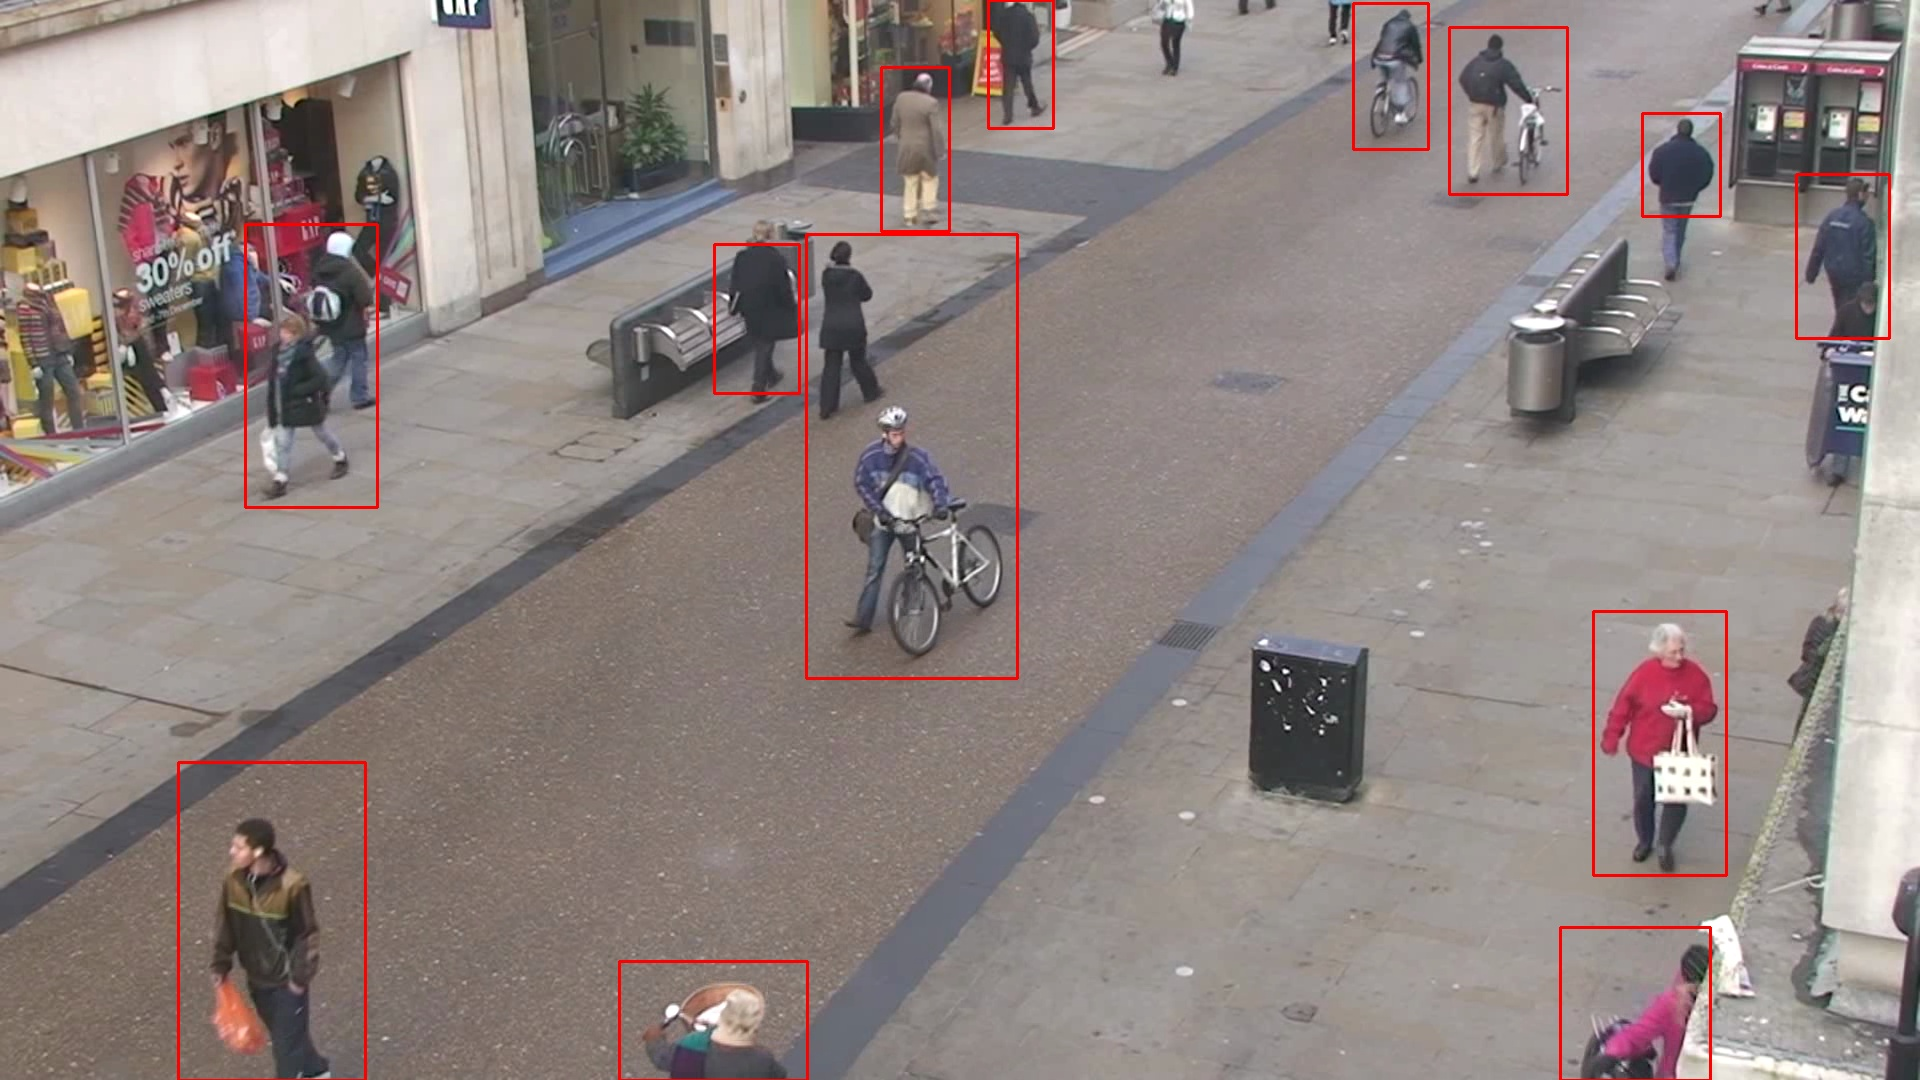

Frames per second: 0.24984448695133119
 
*** Profile printout saved to text file 'prunSW'. 


In [9]:
%%prun -s cumulative -q -l 10 -T prunSW

cap = cv2.VideoCapture('TownCentreXVID.avi')
ret, frame1 = cap.read()

prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
next = np.zeros_like(prvs)
yuv = np.zeros_like(frame1)

num_frames = 5

def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,2] = np.minimum(v*4, 255)
    ret,bgr = cv2.threshold(hsv[...,2],3,255,cv2.THRESH_BINARY) # moving pixels are turned white

    return bgr

start = time.time()
for _ in range(num_frames):
    ret, frame2 = cap.read() # reading from mp4 file
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 1, 5, 1.2, 0)
    bgr = draw_hsv(flow)
    
    # attempt to cleanup the binarized image, would be preferable to accelerate these functions
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(bgr,kernel,iterations = 1)
    closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)

    _, contours, heir = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for i in contours:
        if cv2.contourArea(i) < 3000:
            continue
        (x,y,w,h) = cv2.boundingRect(i)
        cv2.rectangle(frame2, (x,y), (x+w,y+h),(0,0,255),2)
      
    IPython.display.clear_output(wait=True)
    imshow(frame2)
    prvs[:] = next[:]
tottime_sw_opticalflow = time.time() - start
print("Frames per second: " + str(num_frames/tottime_sw_opticalflow))

In [4]:
print(open('prunSW','r').read())
res = !cat prunSW | grep calcOpticalFlowFarneback | awk '{{print $$2}}'
tottime_sw_opticalflow = float(res[0])
print(tottime_sw_opticalflow)

         21358 function calls (20816 primitive calls) in 16.984 seconds

   Ordered by: cumulative time
   List reduced from 265 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001   16.984   16.984 {built-in method builtins.exec}
        1    0.007    0.007   16.983   16.983 <string>:3(<module>)
        5   15.483    3.097   15.483    3.097 {calcOpticalFlowFarneback}
        5    0.421    0.084    0.468    0.094 <string>:12(draw_hsv)
        5    0.000    0.000    0.411    0.082 <ipython-input-2-475e713dbb91>:3(imshow)
        5    0.304    0.061    0.304    0.061 {imencode}
        6    0.289    0.048    0.289    0.048 {method 'read' of 'cv2.VideoCapture' objects}
        1    0.236    0.236    0.236    0.236 {VideoCapture}
       11    0.116    0.011    0.116    0.011 {cvtColor}
        5    0.000    0.000    0.106    0.021 display.py:141(display)
15.483


# Hardware Implementation

In [7]:
%%prun -s tottime -q -l 10 -T prunHW

# read in saved video
cap = cv2.VideoCapture('TownCentreXVID.avi')
ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY) # read the first frame of the video in grayscale
(height,width,channels) = frame1.shape

xFprvs  = mem_manager.cma_array((height,width),np.uint8) # previous image
xFnext  = mem_manager.cma_array((height,width),np.uint8) # next image
xFflowX = mem_manager.cma_array((height,width),np.float32) # horizontal component of flow vector
xFflowY = mem_manager.cma_array((height,width),np.float32) # vertical component of flow vector

xFprvs[:] = prvs[:] # allocate the memory manager for the first frame
num_frames = 5

# IMPORTANT: HSV CONVERSION TAKES A LOT OF TIME TO COMPUTE.. THOSE IMAGE OPERATIONS ARE MASSIVE

# Returns binary thresholded image:
# compute the magnitude of the velocity vectors
# use these vectors to construct a grayscale image
# threshold the image ---> moving pixels are turned white
def draw_hsv(xFflowX, xFflowY, xFnext):
    h, w = xFnext.shape[:2]
    fx, fy = xFflowX, xFflowY
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,2] = np.minimum(v*4, 255) # keep this channel for grayscale
    ret,bgr = cv2.threshold(hsv[...,2],3,255,cv2.THRESH_BINARY) # moving pixels are turned white
    
    return bgr

start = time.time()
for j in range(num_frames):

    ret, frame2 = cap.read() # reading from mp4 file

    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    xFnext[:] = next[:]
    xv2.calcOpticalFlowDenseNonPyrLK(xFprvs, xFnext, xFflowX, xFflowY) # calculate the Dense Optical Flow

    bgr = draw_hsv(xFflowX, xFflowY, xFnext) # return the threshold image for moving objects

    # attempt to cleanup the binarized image, would be preferable to accelerate these functions
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(bgr,kernel,iterations = 1)
    closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)

    _, contours, heir = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for i in contours:
        if cv2.contourArea(i) < 3000:
            continue
        (x,y,w,h) = cv2.boundingRect(i)
        cv2.rectangle(frame2, (x,y), (x+w,y+h),(0,0,255),2)

    xFprvs[:] = xFnext[:]
    

tottime_hw_opticalflow = time.time() - start
print(tottime_hw_opticalflow)
print("Frames per second: " + str(num_frames/tottime_hw_opticalflow))

Sensor {name=12V_power, value=12.0W}
Sensor {name=12V_power, value=11.95W}
Sensor {name=12V_power, value=11.775W}
Sensor {name=12V_power, value=11.825W}
Sensor {name=12V_power, value=11.825W}
6.893123388290405
Frames per second: 0.7253605830549441
 
*** Profile printout saved to text file 'prunHW'. 


In [25]:
print(open('prunHW','r').read())
res = !cat prunHW | grep calcOpticalFlowDenseNonPyrLK | awk '{{print $$2}}'
tottime_hw_opticalflow = float(res[0])

# Profiling the other cv2 functions taking place
res = !cat prunHW | grep erode | awk '{{print $$2}}'
tottime_sw_erosion = float(res[0])

res = !cat prunHW | grep draw_hsv | awk '{{print $$2}}'
tottime_sw_hsv = float(res[0])

res = !cat prunHW | grep erode | awk '{{print $$2}}'
tottime_sw_erosion = float(res[0])

res = !cat prunHW | grep morphologyEx | awk '{{print $$2}}'
tottime_sw_closing = float(res[0])

res = !cat prunHW | grep findContours | awk '{{print $$2}}'
tottime_sw_contours = float(res[0])

res = !cat prunHW | grep VideoCapture | awk '{{print $$2}}'
tottime_sw_videoCap = float(res[0])

         945 function calls in 7.266 seconds

   Ordered by: internal time
   List reduced from 56 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    5.139    1.028    6.425    1.285 <string>:26(draw_hsv)
        5    0.782    0.156    0.782    0.156 {morphologyEx}
        5    0.391    0.078    0.391    0.078 {erode}
        6    0.281    0.047    0.281    0.047 {method 'read' of 'cv2.VideoCapture' objects}
        1    0.236    0.236    0.236    0.236 {VideoCapture}
        1    0.161    0.161    7.263    7.263 <string>:4(<module>)
        6    0.079    0.013    0.079    0.013 {cvtColor}
        5    0.070    0.014    0.070    0.014 {calcOpticalFlowDenseNonPyrLK}
        5    0.069    0.014    0.069    0.014 {findContours}
        5    0.026    0.005    0.026    0.005 {threshold}


[14.0, 3096.6]


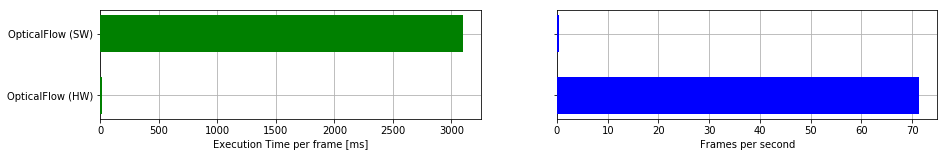

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

TIME_SW_HW   = [t*1000/num_frames for (t) in (tottime_hw_opticalflow, tottime_sw_opticalflow)]
FPS_SW_HW    = [1000/t for (t) in (TIME_SW_HW)]
LABELS       = ['OpticalFlow (HW)','OpticalFlow (SW)']

f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,2))
x_pos = np.arange(len(LABELS))
plt.yticks(x_pos, LABELS)

ax1.barh(x_pos, TIME_SW_HW, height=0.6, color='g', zorder=3)
ax1.invert_yaxis()
ax1.set_xlabel("Execution Time per frame [ms]")
ax1.grid(zorder=0)

ax2.barh(x_pos, FPS_SW_HW, height=0.6, color='b', zorder=3)
ax2.invert_yaxis()
ax2.set_xlabel("Frames per second")
ax2.grid(zorder=0)

plt.show()

# Plot the Results of Image Operations

This cell shows the execution time for the functions called in the algorithm. It is easy to see where the process is taking the longest.

[14.0, 1027.8, 78.2, 156.4, 13.8, 318.6, 56.2]


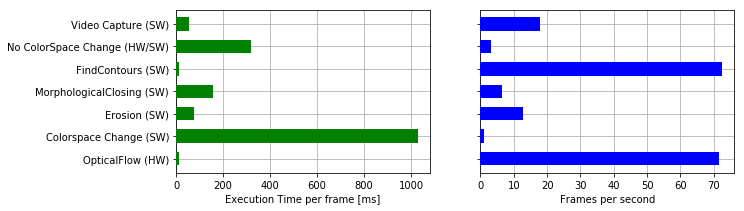

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt

# calculate the FPS if the Colorspace change is removed
times = [tottime_hw_opticalflow, tottime_sw_erosion, tottime_sw_closing, tottime_sw_contours, tottime_sw_videoCap]
tottime_noHSV = sum(times)

TIME_SW_HW   = [t*1000/num_frames for (t) in (tottime_hw_opticalflow, tottime_sw_hsv, tottime_sw_erosion, tottime_sw_closing, tottime_sw_contours, tottime_noHSV, tottime_sw_videoCap)]
print(TIME_SW_HW)
FPS_SW_HW    = [1000/t for (t) in (TIME_SW_HW)]
LABELS       = ['OpticalFlow (HW)','Colorspace Change (SW)', 'Erosion (SW)', 'MorphologicalClosing (SW)', 'FindContours (SW)', 'No ColorSpace Change (HW/SW)', 'Video Capture (SW)']

f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,3))
x_pos = np.arange(len(LABELS))
plt.yticks(x_pos, LABELS)

ax1.barh(x_pos, TIME_SW_HW, height=0.6, color='g', zorder=3)
ax1.invert_yaxis()
ax1.set_xlabel("Execution Time per frame [ms]")
ax1.grid(zorder=0)

ax2.barh(x_pos, FPS_SW_HW, height=0.6, color='b', zorder=3)
ax2.invert_yaxis()
ax2.set_xlabel("Frames per second")
ax2.grid(zorder=0)

plt.show()

# Running Demo

## Run this cell to watch the (slow) demo, press interrupt when complete

In [ ]:
%%prun -s tottime -q -l 10 -T prunHW
import numpy as np
import time

cap = cv2.VideoCapture('TownCentreXVID.avi')

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
(height,width,channels) = frame1.shape

xFprvs  = mem_manager.cma_array((height,width),np.uint8) # previous image
xFnext  = mem_manager.cma_array((height,width),np.uint8) # next image
xFflowX = mem_manager.cma_array((height,width),np.float32) # horizontal component of flow vector
xFflowY = mem_manager.cma_array((height,width),np.float32) # vertical component of flow vector

xFprvs[:] = prvs[:]
yuv = np.zeros_like(frame1) # used to visualize in the YUV color space
num_frames = 2000


def draw_hsv(xFflowX, xFflowY, xFnext):
    h, w = xFnext.shape[:2]
    fx, fy = xFflowX, xFflowY
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,2] = np.minimum(v*4, 255) # use this for grayscale
    ret,bgr = cv2.threshold(hsv[...,2],3,255,cv2.THRESH_BINARY) # moving pixels are turned white
    
    return bgr

try:
    while True:
        start = time.time()
        for j in range(num_frames):
            
            ret, frame2 = cap.read() # reading from mp4 file
            
            next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
            xFnext[:] = next[:]
            xv2.calcOpticalFlowDenseNonPyrLK(xFprvs, xFnext, xFflowX, xFflowY) # calculate the Dense Optical Flow
            
            bgr = draw_hsv(xFflowX, xFflowY, xFnext) # return the threshold image for moving objects

            # attempt to cleanup the binarized image
            kernel = np.ones((5,5),np.uint8)
            dilation = cv2.erode(bgr,kernel,iterations = 1)
            closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)

            _, contours, heir = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for i in contours:
                if cv2.contourArea(i) < 3000:
                    continue
                (x,y,w,h) = cv2.boundingRect(i)
                cv2.rectangle(frame2, (x,y), (x+w,y+h),(0,0,255),2)
            
            imshow(frame2)
            #cv2.imwrite('images/video/image-{}.jpg'.format(j), frame2)
            IPython.display.clear_output(wait=True)
            xFprvs[:] = xFnext[:]            

except KeyboardInterrupt:
    
    print('demo done')

<font color=red size=4>IMPORTANT NOTE</font>: Be sure to run the cell below, shutting down the notebook, before starting a new one. The notebook interface shows "No Kernel", the cell below will incorrectly show a running status [ * ]. You can ignore this an safely close the tab of the notebook.

In [ ]:
%%javascript
Jupyter.notebook.session.delete();